In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [2]:
class MineELU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output
    
class MineReLU(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input_arg):
        output = F.elu(self.fc1(input_arg))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [3]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb, t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [4]:
def sample_batch(data, batch_size, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

In [5]:
def train(data, mine_net,mine_net_optim, batch_size=100, iter_num=int(1e+5), log_freq=int(1e+3)):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data, batch_size), sample_batch(data, batch_size, sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        result.append(mi_lb.item())
        if (i+1) % log_freq == 0:
            print(result[-1]) 
    result = np.asarray(result)
    return result

In [6]:
def ma(a, window_size=100):
    return [np.mean(a[i:(i+window_size)]) for i in range(0,len(a)-window_size)]

In [7]:
cov = [
    [1., .8],
    [.8, 1.]
]
data_X = np.random.multivariate_normal(mean=[0,0], cov=cov, size=1024)

In [8]:
mine_net_cor = MineReLU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X, mine_net_cor, mine_net_optim_cor, batch_size=128)

0.380649209022522
0.3920813798904419
0.6650665998458862
0.5968141555786133
0.39959409832954407
0.4435442090034485
0.27625590562820435
0.13018059730529785
0.5319064259529114
0.45132070779800415
0.6048552989959717
0.6046539545059204
0.565786600112915
0.5666408538818359
0.3080611228942871
0.3932431638240814
0.22126781940460205
0.5402025580406189
0.7230842113494873
0.5976412296295166
0.3151695728302002
0.5115730166435242
0.2866087555885315
0.33230286836624146
0.04701867699623108
0.8243368864059448
0.47963622212409973
0.5573291182518005
0.3989827036857605
0.5148946046829224
0.3945145308971405
0.6808319687843323
0.49284419417381287
0.6286193132400513
0.5094196796417236
0.638890266418457
0.5847952365875244
0.5350714325904846
0.683823823928833
0.43139946460723877
0.5967102646827698
0.2992561459541321
0.37087690830230713
0.5580531358718872
0.43084821105003357
0.518273651599884
0.46528568863868713
0.5660123229026794
0.4447694420814514
0.2187073528766632
0.5947834849357605
0.5305546522140503
0.28

0.4968909865617752


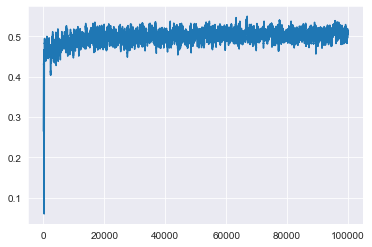

In [9]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

In [18]:
mine_net_cor = MineReLU()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-3)
result_cor = train(data_X / 5,mine_net_cor,mine_net_optim_cor)

0.6180503368377686
0.5147232413291931
0.48144370317459106
0.30011066794395447
0.4768623113632202
0.41318780183792114
0.42991527915000916
0.39036041498184204
0.4983639419078827
0.5655034184455872
0.6114146113395691
0.6590268611907959
0.6055393815040588
0.4819388687610626
0.35318681597709656
0.37125489115715027
0.5474154949188232
0.5090807676315308
0.3441179096698761
0.7329931259155273
0.28925901651382446
0.5934571027755737
0.3345409631729126
0.47968146204948425
0.5216915607452393
0.23896066844463348
0.7088863849639893
0.5388236045837402
0.5240522623062134
0.5496896505355835
0.37795814871788025
0.41812801361083984
0.2615298628807068
0.4623028635978699
0.7102475166320801
0.4063628315925598
0.6021551489830017
0.34365978837013245
0.3385661840438843
0.5065776109695435
0.5991829037666321
0.455694317817688
0.13535559177398682
0.42251816391944885
0.6036609411239624
0.6283966898918152
0.6730669736862183
0.48151645064353943
0.6609517335891724
0.701106071472168
0.6510491371154785
0.266351282596588

0.5235214386880398


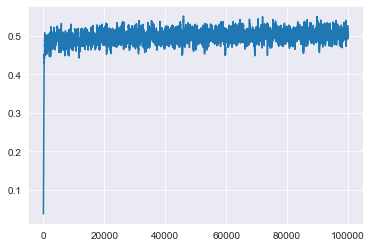

In [20]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma[:])),result_cor_ma[:])